## Feature Related (Numerical)

In [7]:
# aggs = {
#     'uid': ['count'],
#     'is_manual': ['sum', 'mean'],
#     'elapsed_days_succeeded_created': ['mean', 'std', 'max', 'min'],
#     'elapsed_days_created_premium': ['mean', 'std', 'max', 'min'],
#     'elapsed_days_created': ['mean', 'std', 'max', 'min'],
#     'elapsed_days_succeeded_premium': ['mean', 'std', 'max', 'min'],
#     'elapsed_days_succeeded': ['mean', 'std', 'max', 'min'],
#     'created_before_premium': ['sum', 'mean'],
#     'created_after_premium': ['sum', 'mean'],
#     'succeeded_before_premium': ['sum', 'mean'],
#     'succeeded_before_premium': ['sum', 'mean'],
# }
# aggs.update({col: ['sum', 'mean'] for col in service_category_id_cols})

# group_account_df = account_df.groupby(ID).agg(aggs)
# group_account_df.columns = [f'{k}_{v.upper()}' for k, vs in aggs.items() for v in vs]
# group_account_df = group_account_df.reset_index()

### Cyclical Encode

In [8]:
def apply_cyclical(df, str_col):
    # e.g. df['hr'] = df.timestamp.dt.hour; apply_cyclical(df, 'hr')
    # ===== assumes integer array =====
    # ===== assumes min and max exists in array =====
    temp = pd.DataFrame()
    temp['unique_sorted'] = (df[str_col] - df[str_col].min()).sort_values().unique()
    int_max = temp.unique_sorted.max()
    temp['sin'] = np.sin(2 * np.pi * temp.unique_sorted / int_max)
    temp['cos'] = np.cos(2 * np.pi * temp.unique_sorted / int_max)
    temp = temp.set_index('unique_sorted')
    df[f'{str_col}_sin'] = (df[str_col] - df[str_col].min()).map(temp.sin)
    df[f'{str_col}_cos'] = (df[str_col] - df[str_col].min()).map(temp.cos)
    del temp, int_max; gc.collect()

### Rolling Statistic

In [9]:
def apply_mov_stat(df, str_col, list_windows, fix=False, print_option=True):

    # ===== assumes timestamp is aligned =====
    for win in list_windows:
        rolled = df[str_col].rolling(window=win, min_periods=0)
        mov_avg = rolled.mean().reset_index() #.astype(np.float16)
        mov_max = rolled.max().reset_index() #.astype(np.float16)
        mov_min = rolled.min().reset_index() #.astype(np.float16)
        mov_std = rolled.std().reset_index() #.astype(np.float16)
        if win >= 4:
            mov_Q1 = rolled.quantile(0.25).reset_index() #.astype(np.float16)
            mov_Q2 = rolled.quantile(0.5).reset_index() #.astype(np.float16)
            mov_Q3 = rolled.quantile(0.75).reset_index() #.astype(np.float16)

        if fix:
            formula = int((win/2) - win)
            df[f'{str_col}_movavg_{win}'] = mov_avg[f'{str_col}'].shift(formula)
            df[f'{str_col}_movmax_{win}'] = mov_max[f'{str_col}'].shift(formula)
            df[f'{str_col}_movmin_{win}'] = mov_min[f'{str_col}'].shift(formula)
            df[f'{str_col}_movstd_{win}'] = mov_std[f'{str_col}'].shift(formula)
            if win >= 4:
                df[f'{str_col}_movQ1_{win}'] = mov_Q1[f'{str_col}'].shift(formula)
                df[f'{str_col}_movQ2_{win}'] = mov_Q2[f'{str_col}'].shift(formula)
                df[f'{str_col}_movQ3_{win}'] = mov_Q3[f'{str_col}'].shift(formula)
            print()
            del formula
        else:
            df[f'{str_col}_movavg_{win}'] = mov_avg[f'{str_col}']
            df[f'{str_col}_movmax_{win}'] = mov_max[f'{str_col}']
            df[f'{str_col}_movmin_{win}'] = mov_min[f'{str_col}']
            df[f'{str_col}_movstd_{win}'] = mov_std[f'{str_col}']
            if win >= 4:
                df[f'{str_col}_movQ1_{win}'] = mov_Q1[f'{str_col}']
                df[f'{str_col}_movQ2_{win}'] = mov_Q2[f'{str_col}']
                df[f'{str_col}_movQ3_{win}'] = mov_Q3[f'{str_col}']
            print()
        
        if print_option:
            print('Generated features: apply_mov_stat')
            print(f"'{str_col}_movavg_{win}',")
            print(f"'{str_col}_movmax_{win}',")
            print(f"'{str_col}_movmin_{win}',")
            print(f"'{str_col}_movstd_{win}',")
            if win >= 4:
                print(f"'{str_col}_movQ1_{win}',")
                print(f"'{str_col}_movQ2_{win}',")
                print(f"'{str_col}_movQ3_{win}',")
            print()
            
    del win, rolled, mov_avg, mov_max, mov_min, mov_std; gc.collect()
    if any([val for val in list_windows if val >= 4]):
        del mov_Q1, mov_Q2, mov_Q3; gc.collect()

### Shift Features

In [11]:
def apply_shift_feature(df, subject_cols, list_shift, print_option=True):
    for col in subject_cols:
        for step in list_shift:
            df[f'{col}_shift_{step}'] = df[col].shift(int(step))
            
    if print_option:
        for col in subject_cols:
            for step in list_shift:
                print(f"'{col}_shift_{step}',")
        
    del col, step; gc.collect()

### Oneth Feature

In [12]:
def apply_oneth_feature(df, str_col, print_option=True):
    import math
    modify = np.vectorize(math.modf)
    oneth, tenth = modify(df[str_col] / 10)
    df[f'{str_col}_oneth'] = oneth * 10
    
    if print_option:
        print(f"'{str_col}_oneth',")
        
    del tenth; gc.collect()

### nan Binary Features

In [13]:
def apply_isna_feature(df, subject_cols, print_option=True):
    binary_isna = [col+"_isnan" for col in subject_cols]
    df[binary_isna] = df[subject_cols].isna().astype(int)
    
    if print_option:
        for col in binary_isna:
            print(f"'{col}',")
        
    del binary_isna; gc.collect()

### Row nan Count Feature

In [14]:
def apply_row_nan(df, print_option=True):
    df['row_nan'] = df.isna().sum(axis=1).astype(np.int8)
    
    if print_option:
        print("'row_nan',")

### Bruteforce Combination

In [15]:
def bruteforce_combination(df, subject_cols, choose=2, print_option=True):
    from itertools import combinations
    comb = combinations(subject_cols, choose)
    for feat_1, feat_2 in comb:
        df[f'{feat_1}_.+_{feat_2}'] = df[f'{feat_1}'] + df[f'{feat_1}']
        df[f'{feat_1}_.-_{feat_2}'] = df[f'{feat_1}'] - df[f'{feat_1}']
        df[f'{feat_1}_.*_{feat_2}'] = df[f'{feat_1}'] * df[f'{feat_1}']
        df[f'{feat_1}_./_{feat_2}'] = df[f'{feat_1}'] / df[f'{feat_1}']
            
    if print_option:
        for feat_1, feat_2 in comb:
            print(f"'{feat_1}_.+_{feat_2}',")
            print(f"'{feat_1}_.-_{feat_2}',")
            print(f"'{feat_1}_.*_{feat_2}',")
            print(f"'{feat_1}_./_{feat_2}',")
            
    del comb, feat_1, feat_2; gc.collect()

### Polynomial Features

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

x = pd.DataFrame(np.array([[1,2,3],[2,4,7],[3,4,4]]).transpose(), columns=['one', 'two', 'three']).astype(np.int8)
x

,one,two,three
0,1,2,3
1,2,4,4
2,3,7,4


In [32]:
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False, order='C')
poly.fit_transform(x)

array([[ 1.,  2.,  3.,  2.,  3.,  6.,  6.],
       [ 2.,  4.,  4.,  8.,  8., 16., 32.],
       [ 3.,  7.,  4., 21., 12., 28., 84.]])

In [33]:
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2', 'x0 x1 x2']

### Binning

In [98]:
class apply_bin:
    def cut(df, subject_cols, n_bin):
        for col in subject_cols:
            df[f'{col}_c_bin_{n_bin}'] = pd.cut(df[col], bins=n_bin, labels=False)
    def qcut(df, subject_cols, n_q):
        for col in subject_cols:
            df[f'{col}_q_bin_{n_q}'] = pd.qcut(df[col], q=n_q, labels=False)

In [99]:
x_bin = pd.DataFrame(np.random.randn(1000), columns=['gauss'])
x_bin.head()

,gauss
0,0.110594
1,0.524689
2,-2.079909
3,-0.380613
4,-0.367914


gauss_c_bin_5
2    507
1    236
3    220
4     24
0     13
Name: gauss_c_bin_5, dtype: int64


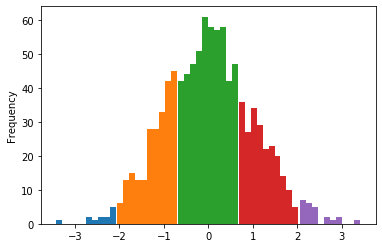

In [132]:
apply_bin.qcut(x_bin, ['gauss'], 5)
apply_bin.cut(x_bin, ['gauss'], 5)
print(x_bin.columns[-1])
print(x_bin[x_bin.columns[-1]].value_counts())
for i in range(x_bin[x_bin.columns[-1]].unique().shape[0]):
    x_bin[x_bin[x_bin.columns[-1]] == i].gauss.plot.hist()

gauss_q_bin_5
4    200
3    200
2    200
1    200
0    200
Name: gauss_q_bin_5, dtype: int64


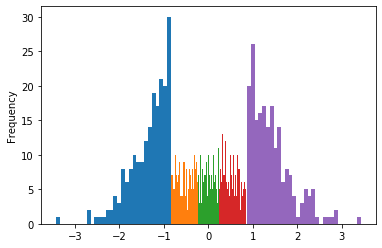

In [133]:
print(x_bin.columns[-2])
print(x_bin[x_bin.columns[-2]].value_counts())
for i in range(x_bin[x_bin.columns[-2]].unique().shape[0]):
    x_bin[x_bin[x_bin.columns[-2]] == i].gauss.plot.hist(bins=30)